# Deconvnet on VGG16 using keras

In [18]:
import numpy as np
from keras import layers
from keras.activations import *
from keras.models import Model
from keras.applications import vgg16, imagenet_utils
import keras.backend as K
import cv2
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
class convolution():
    def __init__(self, layer):
        self.layer = layer
        W = layer.get_weights()[0]
        b = layer.get_weights()[1]
        n_filters = W.shape[3]
        n_row = W.shape[0]
        n_col = W.shape[1]
        
        
        inp = layers.Input(layer.input_shape[1:])
        out = layers.Conv2D(n_filters, kernel_size=(n_row,n_col), padding="same", weights = [W,b])(inp)
        self.conv_up_func = K.function([inp], [out])
        
        #flip each layer horizontally and vertically
        # shape (row, col, channel, filters) changes to (row, col, filters, channel)
        W = np.transpose(W,(0,1,3,2))
        W = W[::-1, ::-1, :, :]
        n_filters = W.shape[3]
        n_row = W.shape[0]
        n_col = W.shape[1]
        b = np.zeros(n_filters)
        inp = layers.Input(layer.output_shape[1:])
        out = layers.Conv2D(n_filters, kernel_size=(n_row,n_col), padding="same", weights = [W,b])(inp)
        self.conv_down_func = K.function([inp], [out])
        
    def up(self, data):
        self.up_data = self.conv_up_func([data])[0]
        return self.up_data
    
    def down(self, data):
        self.down_data = self.conv_down_func([data])[0]
        return self.down_data

In [3]:
class dense():
    def __init__(self,layer):
        self.layer = layer
        W = layer.get_weights()[0]
        b = layer.get_weights()[1]
        inp = layers.Input(layer.input_shape[1:])
        out = layers.Dense(layer.output_shape[1], weights = [W,b])(inp)
        self.dense_up_func = K.function([inp], [out])
        
        W = W.transpose()
        b = np.zeros(layer.input_shape[1])
        inp = layers.Input(layer.output_shape[1:])
        out = layers.Dense(layer.input_shape[1], weights =[W,b])(inp)
        self.dense_down_func = K.function([inp], [out])
        
    def up(self, data):
        self.up_data = self.dense_up_func([data])[0]
        return self.up_data
    
    def down(self, data):
        self.down_data = self.dense_down_func([data])[0]
        return self.down_data

In [4]:
class activation():
    def __init__(self, layer):
        self.layer = layer
        self.activation = layer.activation
        
        inp = K.placeholder(layer.output_shape)
        out = self.activation(inp)
        
        #same activation for both forward and backward pass
        self.act_up_func = K.function([inp], [out])
        self.act_down_func = K.function([inp], [out])
        
    def up(self, data):
        self.up_data = self.act_up_func([data])[0]
        return self.up_data
    
    def down(self, data):
        self.down_data = self.act_down_func([data])[0]
        return self.down_data

In [5]:
class flatten():
    def __init__(self, layer):
        self.layer = layer
        self.inp_shape = layer.input_shape[1:]
        
        inp = layers.Input(layer.input_shape[1:])
        out = layers.Flatten()(inp)
        
        self.flatten_up_func = K.function([inp], [out])
        
    def up(self, data):
        self.up_data = self.flatten_up_func([data])[0]
        return self.up_data
    
    def down(self,data):
        new_shape = [data.shape[0]] + list(self.inp_shape)
        self.down_data = np.reshape(data, new_shape)
        return self.down_data

In [6]:
class input_new():
    def __init__(self, layer):
        self.layer = layer
    
    def up(self, data):
        self.up_data = data
        return self.up_data
    
    def down(self, data):
        self.down_data = data
        return self.down_data

In [7]:
class pooling():
    def __init__(self, layer):
        self.layer = layer
        self.poolsize = layer.pool_size
        self.padding = layer.padding
        self.strides = layer.strides
        
    def up(self, data):
        switch = np.zeros(data.shape)
        row_pool = self.poolsize[0]
        col_pool = self.poolsize[1]
        out_shape = list(data.shape)
        out_shape[1] = out_shape[1] / row_pool
        out_shape[2] = out_shape[2] / col_pool
        pooled = np.zeros(out_shape)
        
        for sample in range(data.shape[0]):
            for row in range(out_shape[1]):
                for col in range(out_shape[2]):
                    for channel in range(data.shape[3]):
                        block = data[sample, row * row_pool : (row+1) * row_pool, col * col_pool : (col+1) * col_pool, channel]
                        max_val = block.max()
                        pooled[sample, row, col, channel] = max_val
                        max_col_index = block.argmax(axis=1)
                        max_cols = block.max(axis=1)
                        max_row = max_cols.argmax()
                        max_col = max_col_index[max_row]
                        switch[sample, row * row_pool + max_row, col * col_pool + max_col, channel] = 1
        self.switch = switch
        self.up_data = pooled
        return self.up_data
    
    def down(self, data):
        tile = np.ones((1,(self.switch).shape[1]/data.shape[1], (self.switch).shape[2]/data.shape[2],1))
        out = np.kron(data, tile)
        unpooled = out * self.switch
        self.down_data = unpooled
        return self.down_data

In [15]:
def visualize(data, layer_name, feature, t="all"):
    
    output_layers = []
    for l in (model.layers):
        if(isinstance(l,layers.Conv2D)):
            output_layers.append(convolution(l))
            output_layers.append(activation(l))
        elif(isinstance(l,layers.InputLayer)):
            output_layers.append(input_new(l))
        elif(isinstance(l,layers.MaxPooling2D)):
            output_layers.append(pooling(l))
        elif(isinstance(l,layers.Flatten)):
            output_layers.append(flatten(l))
        elif(isinstance(l,layers.Dense)):
            output_layers.append(dense(l))
            output_layers.append(activation(l))
        elif(isinstance(l,layers.Activation)):
            output_layers.append(activation(l))
        else:
            print "Cannot Handle this"
            print l.get_config()
            return
        if(l.name == layer_name):
            break
            
    output_layers[0].up(data)
    for i in range(1, len(output_layers)):
        output_layers[i].up(output_layers[i-1].up_data)
        
        
    output = output_layers[-1].up_data
    assert output.ndim == 2 or output.ndim == 4
    if output.ndim == 2:
        feature_map = output[:, feature]
    else:
        feature_map = output[:, :, :, feature]
    
    if(t=="max"):
        max_activation = feature_map.max()
        temp = feature_map == max_activation
        feature_map = feature_map * temp

    output = np.zeros(output.shape)
    if output.ndim == 2:
        output[:, feature] = feature_map
    else:
        output[:, :, :, feature] = feature_map
    
    
    output_layers[-1].down(output)
    for i in range(len(output_layers)-2,-1,-1):
        output_layers[i].down(output_layers[i+1].down_data)
    
    deconv = output_layers[0].down_data
    deconv = deconv.squeeze()
    deconv = deconv - deconv.min()
    deconv *= 1.0 / (deconv.max()+ 1e-8)
    deconv = deconv[:, :, ::-1]
    uint8_deconv = (deconv*255).astype(np.uint8)
    img = Image.fromarray(uint8_deconv, 'RGB')
    return img

In [29]:
from random import randint


def plotting(img_path, layer, n_features=1):
    
    
    current_layer = model.get_layer(name=layer)
    max_filters = 0
    try:
        max_filters = (current_layer.get_weights()[0]).shape[3]
    except:
        max_filters = (current_layer.get_weights()[0]).shape[1]
    if(n_features > max_filters):
        print "This layer has only ", max_filters, " filters"
        return
    
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224,224))
    img_array = np.array(img)
    img_array = img_array.astype(float)
    img_array = img_array[np.newaxis, :]
    img_array = imagenet_utils.preprocess_input(img_array)
    
    plt.clf()
    plt.close()
    
    fig_size = plt.rcParams["figure.figsize"]

    fig_size[0] = 3 * 3
    fig_size[1] = 3 * n_features
    plt.rcParams["figure.figsize"] = fig_size
    
    _, ax = plt.subplots(n_features,3)

    for i in range(n_features):
        idx = randint(0,max_filters-1)
        if(n_features>1):
            ax[i,0].imshow(img)
            ax[i,0].set_title("Orignal image")
            ax[i,1].imshow(visualize(img_array, layer, idx, "max"))
            ax[i,1].set_title("Max activation on layer " + str(idx))
            ax[i,2].imshow(visualize(img_array, layer, idx, "all"))
            ax[i,2].set_title("All activation on layer " + str(idx))
        else:
            ax[0].imshow(img)
            ax[0].set_title("Orignal image")
            ax[1].imshow(visualize(img_array, layer, idx, "max"))
            ax[1].set_title("Max activation on layer " + str(idx))
            ax[2].imshow(visualize(img_array, layer, idx, "all"))
            ax[2].set_title("All activation on layer " + str(idx))

    plt.show()

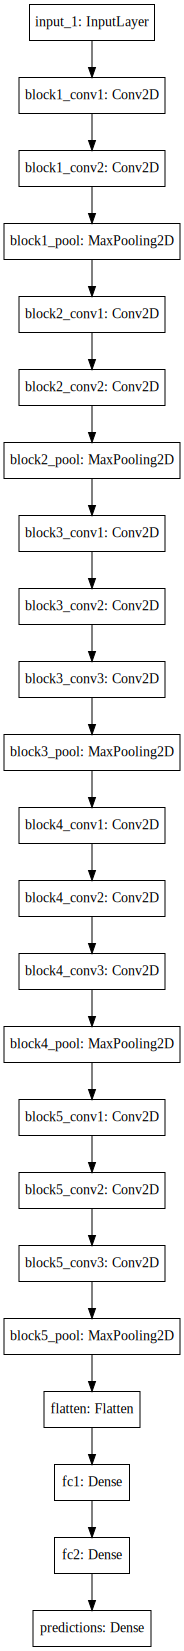

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

K.clear_session()
model = vgg16.VGG16(weights = 'imagenet', include_top = True)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

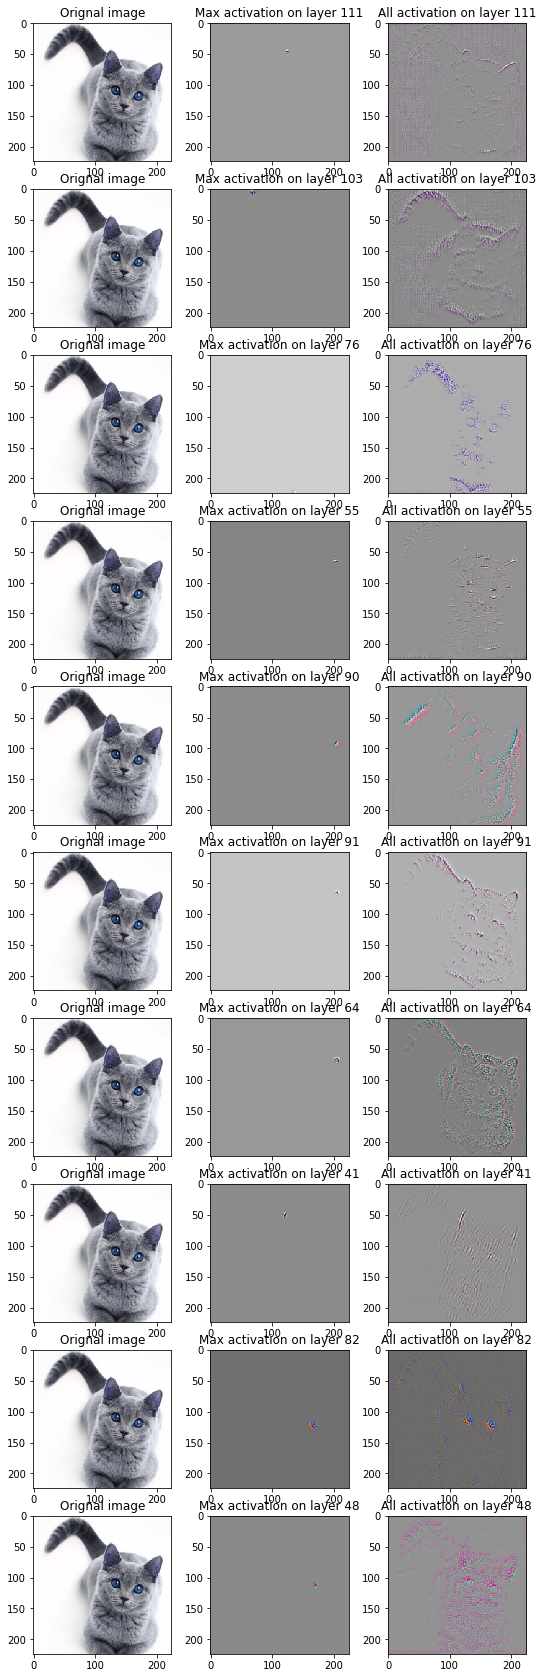

In [22]:
plotting("./cat3.jpg", "block2_conv2", 10)

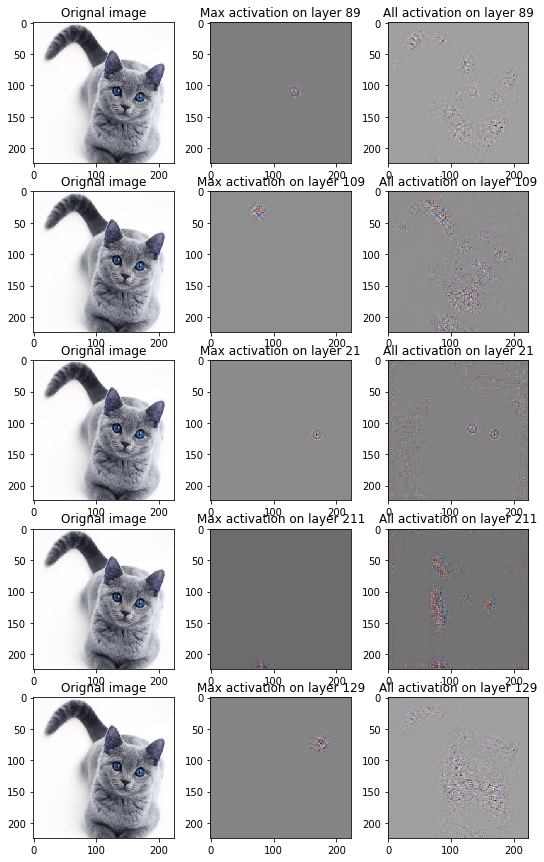

In [23]:
plotting("./cat3.jpg", "block3_conv3", 5)

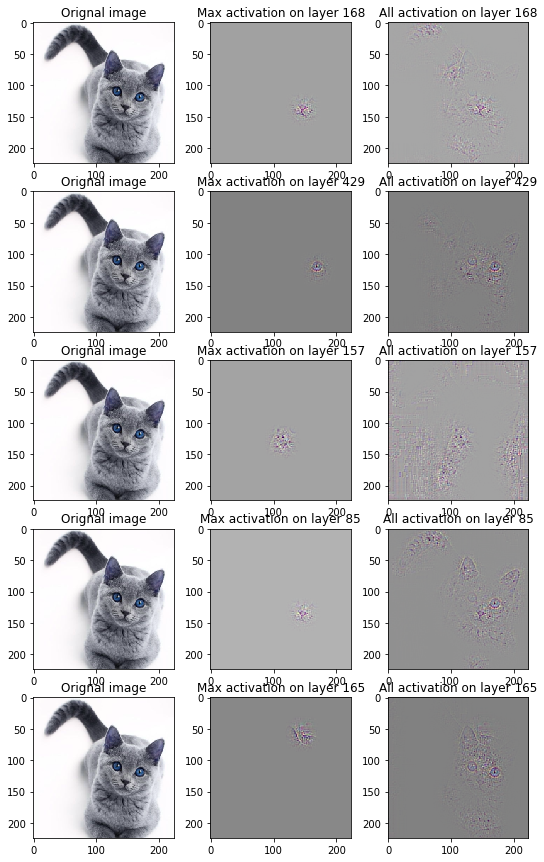

In [24]:
plotting("./cat3.jpg", "block4_conv1", 5)